In [ ]:
import os
import cv2
import math
import random
import zipfile
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

# 1. Download the Dataset and Understand the Format

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##  Extract the zip file

In [ ]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/datasets/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('faces')

with zipfile.ZipFile('/content/drive/MyDrive/datasets/car.zip', 'r') as zip_ref:
    zip_ref.extractall('non_faces')

# 2. Generate the Data Matrix and the Label vector

## a. Convert every image into a vector of 10304 values corresponding to the image size.
`load_images`: for each subject, load its images sorted from 1 to 10 in as one vector of size 10304 for each image. Returns a 2D list of 400 images with 10304 features.

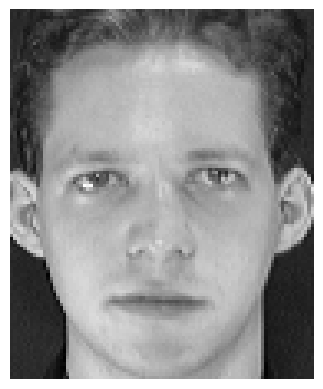

In [ ]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

# Directory containing the extracted dataset
dataset_dir = "faces"

# Function to load images from a directory and convert them to vectors
def load_images(directory):
    images = []
    for subject_id in range(1, 41):
        for img_id in range(1, 11):
            img_path = os.path.join(directory, "s" + str(subject_id), str(img_id) + ".pgm")
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img_vector = img.flatten()  # Convert the 2D image array into a 1D vector
            images.append(img_vector)
    return images

# Load images and convert them into vectors
images = load_images(dataset_dir)

# Reshape the flattened vector back into a 2D array
first_image = np.array(images[0]).reshape(112, 92)

# Plot the image
plt.imshow(first_image, cmap='gray')
plt.axis('off')  # Turn off axis labels
plt.show()

## b. Stack the 400 vectors into a single Data Matrix D and generate the label vector y. The labels are integers from 1:40 corresponding to the subject id.

In [ ]:
# Stack the vectors into a single Data Matrix
D = np.vstack(images)

# generate the label vector
labels = np.repeat(np.arange(1, 41), 10).reshape(-1, 1).ravel()

# 3. Split the Dataset into Training and Test sets

## a. From the Data Matrix D400x10304 keep the odd rows for training and the even rows for testing. This will give you 5 instances per person for training and 5 instances per person for testing.

In [ ]:
# from sklearn.preprocessing import StandardScaler

# Split the Data Matrix into training and test sets
X_train = D[1::2]  # Keep the odd rows for training
X_test = D[::2]  # Keep the even rows for testing

# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

# Print the shapes of the training and test sets to verify
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (200, 10304)
Shape of X_test: (200, 10304)


## b. Split the labels vector accordingly.

In [ ]:
# Split the labels vector accordingly
y_train = labels[1::2]  # Corresponding labels for training set
y_test = labels[::2]  # Corresponding labels for test set

print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of y_train: (200,)
Shape of y_test: (200,)


# 4. Classification using PCA

In [ ]:
def prepare_pca(X_train):
    m = np.shape(X_train)[0]

    mean = np.mean(X_train, axis=0)
    centralized_matrix = X_train - mean

    covariance_matrix = np.cov(centralized_matrix, rowvar=False) * (m-1) / m
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    return eigenvalues, eigenvectors

In [ ]:
def train_pca(eigenvalues, eigenvectors, alpha):
    r = 0
    current_sum = 0
    total_sum = np.sum(eigenvalues)
    for i in range(eigenvalues.shape[0]):
        current_sum += eigenvalues[i]
        r += 1
        if current_sum / total_sum >= alpha:
            break

    projection_matrix = eigenvectors[:, :r]
    return projection_matrix

In [ ]:
def test_pca_lda(projection_matrix, X_train, X_test, y_train, y_test, k_nn):
    projected_X_train = np.dot(X_train, projection_matrix)
    projected_X_test = np.dot(X_test, projection_matrix)
    projected_X_train = np.real(projected_X_train)
    projected_X_test = np.real(projected_X_test)

    classifier = KNeighborsClassifier(n_neighbors=k_nn)
    classifier.fit(projected_X_train, y_train)
    y_pred = classifier.predict(projected_X_test)

    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

Accuracy for alpha = 0.75: 92.50%
Accuracy for alpha = 0.8: 93.00%
Accuracy for alpha = 0.85: 94.00%
Accuracy for alpha = 0.9: 94.50%
Accuracy for alpha = 0.95: 93.50%


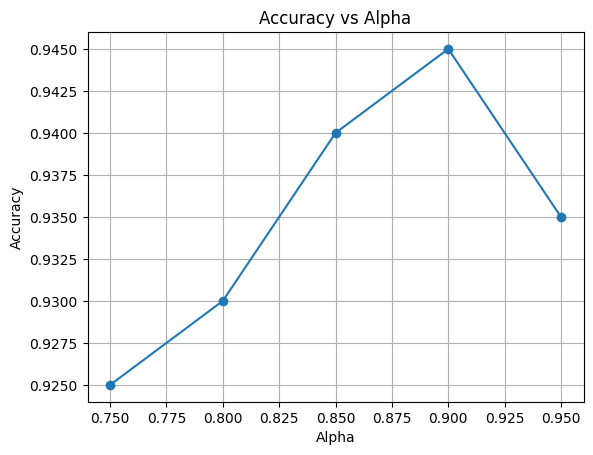

In [ ]:
alpha = [0.75, 0.8, 0.85, 0.9, 0.95]
pca_accuracies_1 = []

eigenvalues, eigenvectors = prepare_pca(X_train)
for a in alpha:
    projection_matrix = train_pca(eigenvalues, eigenvectors, a)
    accuracy = test_pca_lda(projection_matrix, X_train, X_test, y_train, y_test, 1)
    pca_accuracies_1.append(accuracy)
    print(f"Accuracy for alpha = {a}: {accuracy*100:.2f}%")

plt.plot(alpha, pca_accuracies_1, marker='o')
plt.title('Accuracy vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

## Can you find a relation between alpha and classification accuracy?
**YES**. With increasing `alpha`, the accuracy increases. The accuracy only decreased after alpha is 0.95

# 5. Classification Using LDA

implementing this pseudo-code:


In [ ]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from scipy import linalg

def compute_means(train_data):
    class_means = []
    overall_mean = np.mean(train_data, axis=0)
    for i in range(0, train_data.shape[0], 5):
        class_data = train_data[i:i+5]
        class_mean = np.mean(class_data, axis=0)
        class_means.append(class_mean)
    return np.array(class_means), overall_mean

def compute_sb(class_means, overall_mean, n_k):
    sb = np.zeros((class_means.shape[1], class_means.shape[1]))
    for class_mean in class_means:
        diff = class_mean - overall_mean
        sb += (np.outer(diff, diff) * n_k)
    return sb

def compute_within_class_scatter(train_data, class_means):
    s = np.zeros((train_data.shape[1], train_data.shape[1]))
    for i in range(0, train_data.shape[0], 5):
        class_data = train_data[i:i+5, :]
        zi = class_data - class_means[i//5]
        s += np.dot(zi.T, zi)
    return s

def train_lda(X_train, m, n_k):
    class_means, overall_mean = compute_means(X_train)

    sb = compute_sb(class_means, overall_mean, n_k)

    s = compute_within_class_scatter(X_train, class_means)

    eigenvalues, eigenvectors = np.linalg.eig(np.dot(linalg.pinv(s), sb))

    # Sort eigenvalues and eigenvectors
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    r = m-1
    projection_matrix = eigenvectors[:, :r]
    return projection_matrix

In [ ]:
projection_matrix = train_lda(X_train, 40, 5)
lda_accuracy1 = test_pca_lda(projection_matrix, X_train, X_test, y_train, y_test, 1)
print(f"Accuracy for lda: {lda_accuracy1*100:.2f}%")

(40, 10304)
(10304,)
(10304, 10304)
[[ 28496.8  27128.2  27372.4 ...  -3977.2  -3511.6    539. ]
 [ 27128.2  28448.8  27518.6 ...  -2697.2  -2349.2   1781.6]
 [ 27372.4  27518.6  28698.4 ...  -3472.2   -923.2   3416.2]
 ...
 [ -3977.2  -2697.2  -3472.2 ... 140034.   83425.8  64222.2]
 [ -3511.6  -2349.2   -923.2 ...  83425.8  99585.6  82754.4]
 [   539.    1781.6   3416.2 ...  64222.2  82754.4 104148.8]]
(10304, 10304)
(10304, 39)
Accuracy for lda: 96.00%


## Compare the results to PCA results



# 6. Classifier tunning

In [ ]:
def classifier_tuning(X_train, X_test, y_train, y_test, k_nn):
    pca_accuracy = []
    lda_accuracy = []

    eigenvalues, eigenvectors = prepare_pca(X_train)
    pca_projection_matrix = train_pca(eigenvalues, eigenvectors, 0.9)

    lda_projection_matrix = train_lda(X_train, 40, 5)

    for k in k_nn:
        pca_accuracy.append(test_pca_lda(pca_projection_matrix, X_train, X_test, y_train, y_test, k))
        lda_accuracy.append(test_pca_lda(lda_projection_matrix, X_train, X_test, y_train, y_test, k))
    return pca_accuracy, lda_accuracy

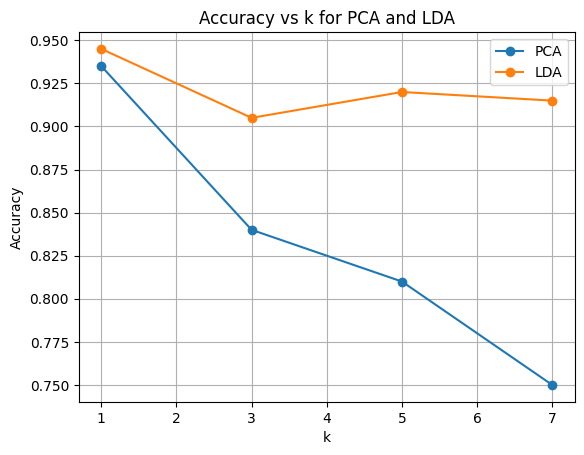

In [ ]:
k_nn = list(range(1, 8, 2))
pca_accuracy, lda_accuracy = classifier_tuning(X_train, X_test, y_train, y_test, k_nn)
plt.plot(k_nn, pca_accuracy, marker='o', label='PCA')
plt.plot(k_nn, lda_accuracy, marker='o', label='LDA')
plt.title('Accuracy vs k for PCA and LDA')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# 7. Compare vs Non-Face Images

## Load non-face dataset

In [ ]:
photos_paths = []

for root, dirs, files in os.walk('/content/non_faces'):
    for file in files:
        if file.endswith('.jpg'):
            photos_paths.append(os.path.join(root, file))
print(f'number of non face imgs: {len(photos_paths)}')

number of non face imgs: 968


## reshape and grey scale

In [ ]:
non_face_data = []

for i in photos_paths:
    img = Image.open(i)
    img = img.resize((92,112))
    np_img = np.array(img)
    np_img = cv2.cvtColor(np_img, cv2.COLOR_BGR2GRAY)
    non_face_data.append(np_img.reshape(-1))

non_face_np_data = np.array(non_face_data)
print(img)

<PIL.Image.Image image mode=RGB size=92x112 at 0x7FF5A6A77310>


In [ ]:
# convert the flattened np array to image
def np_array_to_img(array):
    array = np.reshape(array, (112, 92))
    data = Image.fromarray(array)
    return data

## img after reshape and Grey scale

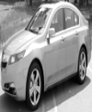

In [ ]:
np_array_to_img(non_face_np_data[3])

## Split the data into train and test

In [ ]:
from sklearn.preprocessing import StandardScaler

face_data = D

train_non_face = np.array(non_face_np_data[:600])
test_non_face = np.array(non_face_np_data[600:900])

train_face = face_data[1::2]
test_face = face_data[::2]

train_face_no_face = np.concatenate((train_face, train_non_face), axis=0)
test_face_no_face = np.concatenate((test_face, test_non_face), axis=0)

sc = StandardScaler()
norm_train_face_no_face = sc.fit_transform(train_face_no_face)
norm_test_face_no_face = sc.transform(test_face_no_face)

print(train_face_no_face.shape)
print(test_face_no_face.shape)

train_face_no_face_labels = np.concatenate((np.repeat(1, 200), np.repeat(2, len(train_non_face)))).reshape(-1, 1)
test_face_no_face_labels = np.concatenate((np.repeat(1, 200), np.repeat(2, len(test_non_face)))).reshape(-1, 1)

print(f"rows number of train data {len(train_face_no_face)}")
print(f"rows number of test data {len(test_face_no_face)}")
print(train_face_no_face_labels.shape)
print(test_face_no_face_labels.shape)

(800, 10304)
(500, 10304)
rows number of train data 800
rows number of test data 500
(800, 1)
(500, 1)


In [ ]:
def pca(train_face_no_face, alpha=0.9):
    eigenvalues, eigenvectors = prepare_pca(train_face_no_face)
    return train_pca(eigenvalues, eigenvectors, alpha)

In [ ]:
from scipy import linalg

def lda(train_face_no_face):
    D1 = train_face_no_face[:200]
    D2 = train_face_no_face[200:]

    mean1 = np.mean(D1, axis=0)
    mean2 = np.mean(D2, axis=0)

    means_dif = mean1 - mean2
    B = np.outer(means_dif, means_dif)

    Z1 = D1 - mean1
    Z2 = D2 - mean2

    S1 = np.dot(Z1.T, Z1)
    S2 = np.dot(Z2.T, Z2)
    S = S1 + S2

    S_inv = linalg.pinv(S)

    eig_val, eig_vec = np.linalg.eig(np.dot(S_inv, B))

    idx = eig_val.argsort()[::-1]
    eigenvectors = eig_vec[:, idx]
    projection_matrix = eigenvectors[:, :1]
    return projection_matrix

In [ ]:
def get_accuracy(projection_matrix, train_face_no_face, train_face_no_face_labels, test_face_no_face, test_face_no_face_labels):
    projected_X_train = np.dot(train_face_no_face, projection_matrix)
    projected_X_train = np.real(projected_X_train)

    projected_X_test = np.dot(test_face_no_face, projection_matrix)
    projected_X_test = np.real(projected_X_test)

    classifier = KNeighborsClassifier(n_neighbors=1)

    classifier.fit(projected_X_train, train_face_no_face_labels.ravel())
    y_pred = classifier.predict(projected_X_test)

    accuracy = accuracy_score(test_face_no_face_labels.ravel(), y_pred)*100

    correctly_classified_images = [idx for idx, pred_label in enumerate(y_pred) if pred_label == test_face_no_face_labels[idx]]
    incorrectly_classified_images = [idx for idx, pred_label in enumerate(y_pred) if pred_label != test_face_no_face_labels[idx]]
    return accuracy, correctly_classified_images, incorrectly_classified_images

In [ ]:
def print_results(accuracy, correctly_classified_images, incorrectly_classified_images, test_face_no_face):
    print(f"the accuracy is {accuracy:.2f}%")

    print(f"Number of suceesses= {len(correctly_classified_images)} / {test_face_no_face.shape[0]}")
    print(f"Number of failures= {len(incorrectly_classified_images)} / {test_face_no_face.shape[0]}")

    fig, axes = plt.subplots(1, 2)
    # Plot the images
    img1 = np_array_to_img(test_face_no_face[correctly_classified_images[0]])
    img2 = np_array_to_img(test_face_no_face[incorrectly_classified_images[0]])
    axes[0].imshow(img1)
    axes[0].set_title('Success case:')
    axes[0].axis('off')

    axes[1].imshow(img2)
    axes[1].set_title('Failure case:')
    axes[1].axis('off')

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()



PCA (alpha = 0.9) with 200 non-face train images:
the accuracy is 85.80%
Number of suceesses= 429 / 500
Number of failures= 71 / 500


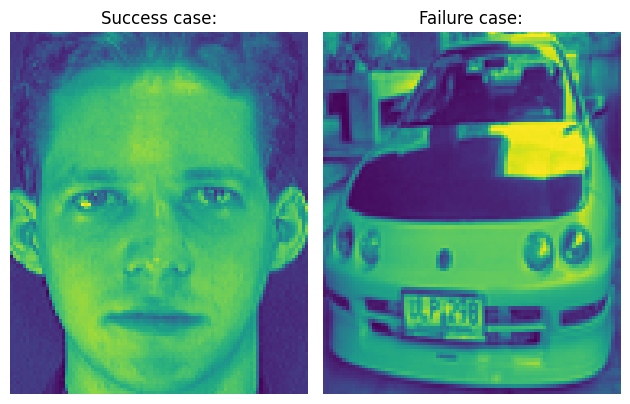


PCA (alpha = 0.9) with 300 non-face train images:
the accuracy is 90.40%
Number of suceesses= 452 / 500
Number of failures= 48 / 500


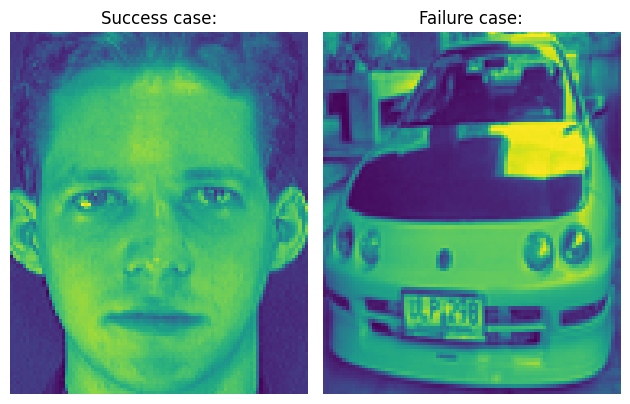


PCA (alpha = 0.9) with 400 non-face train images:
the accuracy is 91.80%
Number of suceesses= 459 / 500
Number of failures= 41 / 500


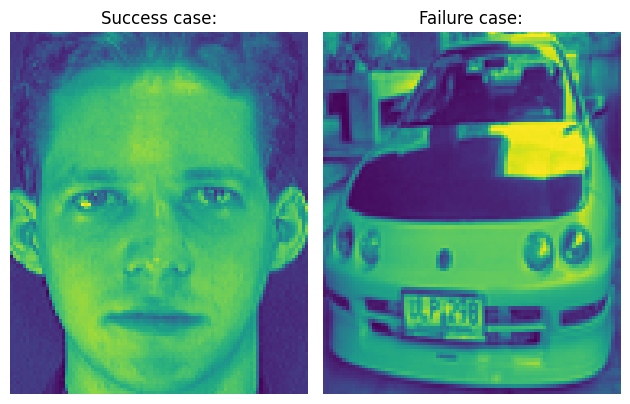


PCA (alpha = 0.9) with 500 non-face train images:
the accuracy is 93.40%
Number of suceesses= 467 / 500
Number of failures= 33 / 500


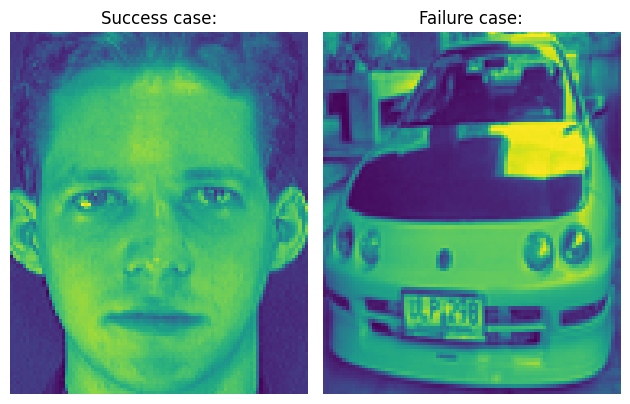


PCA (alpha = 0.9) with 600 non-face train images:
the accuracy is 93.60%
Number of suceesses= 468 / 500
Number of failures= 32 / 500


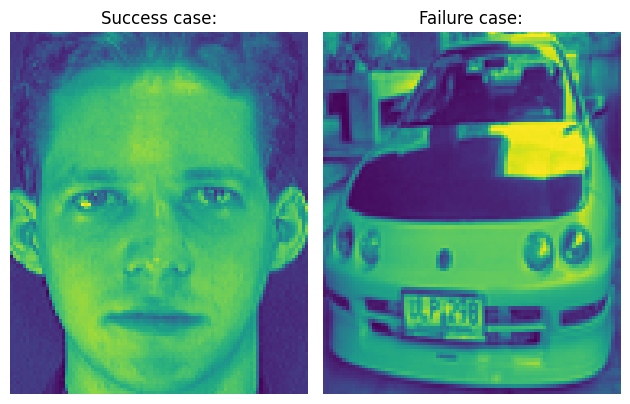

In [ ]:
for i in [200, 300, 400, 500, 600]:
    train_face_no_face_slice = norm_train_face_no_face[:200+i];
    train_labels_slice = train_face_no_face_labels[:200+i];

    pca_projection_mat = pca(train_face_no_face_slice)

    print(f"\nPCA (alpha = 0.9) with {i} non-face train images:")
    accuracy, correctly_classified_images, incorrectly_classified_images = get_accuracy(pca_projection_mat, train_face_no_face_slice, train_labels_slice, norm_test_face_no_face, test_face_no_face_labels)
    print_results(accuracy, correctly_classified_images, incorrectly_classified_images, test_face_no_face)


In [ ]:
for i in [200, 300, 400, 500, 600]:
    train_face_no_face_slice = norm_train_face_no_face[:200+i];
    train_labels_slice = train_face_no_face_labels[:200+i];

    lda_projection_mat = lda(train_face_no_face_slice)

    print(f"\nLDA with {i} non-face train images:")
    accuracy, correctly_classified_images, incorrectly_classified_images = get_accuracy(lda_projection_mat, train_face_no_face_slice, train_labels_slice, norm_test_face_no_face, test_face_no_face_labels)
    print_results(accuracy, correctly_classified_images, incorrectly_classified_images, test_face_no_face)



LDA with 200 non-face train images:
the accuracy is 95.80%
Number of suceesses= 479 / 500
Number of failures= 21 / 500


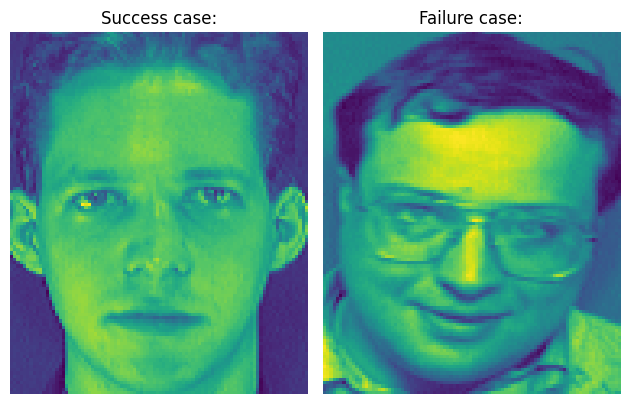

In [ ]:
train_face_no_face_slice = norm_train_face_no_face[:400];
train_labels_slice = train_face_no_face_labels[:400];

lda_projection_mat = lda(train_face_no_face_slice)

print("\nLDA with 200 non-face train images:")
accuracy, correctly_classified_images, incorrectly_classified_images = get_accuracy(lda_projection_mat, train_face_no_face_slice, train_labels_slice, norm_test_face_no_face, test_face_no_face_labels)
print_results(accuracy, correctly_classified_images, incorrectly_classified_images, test_face_no_face)



LDA with 300 non-face train images:
the accuracy is 96.60%
Number of suceesses= 483 / 500
Number of failures= 17 / 500


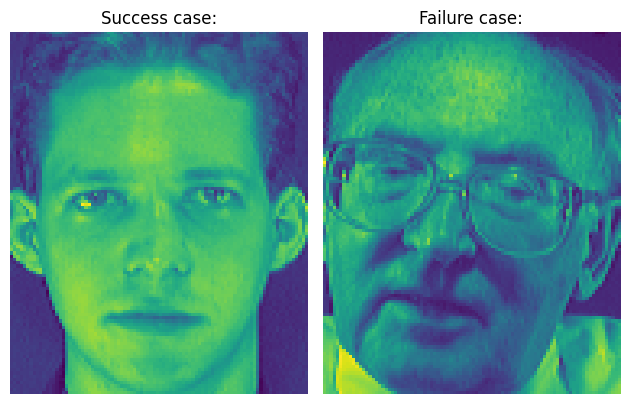

In [ ]:
train_face_no_face_slice = norm_train_face_no_face[:500];
train_labels_slice = train_face_no_face_labels[:500];

lda_projection_mat = lda(train_face_no_face_slice)

print("\nLDA with 300 non-face train images:")
accuracy, correctly_classified_images, incorrectly_classified_images = get_accuracy(lda_projection_mat, train_face_no_face_slice, train_labels_slice, norm_test_face_no_face, test_face_no_face_labels)
print_results(accuracy, correctly_classified_images, incorrectly_classified_images, test_face_no_face)


LDA with 400 non-face train images:
the accuracy is 94.60%
Number of suceesses= 473 / 500
Number of failures= 27 / 500


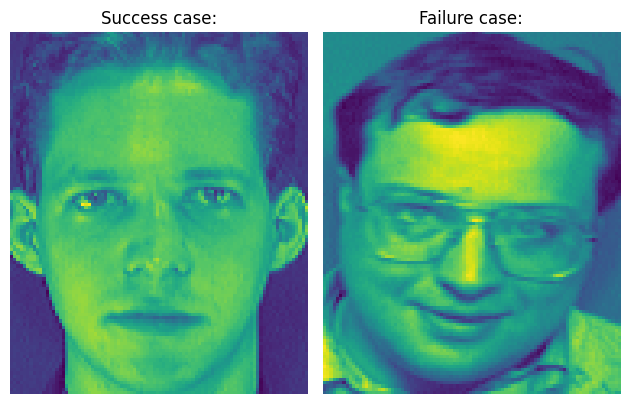

In [ ]:
train_face_no_face_slice = norm_train_face_no_face[:600];
train_labels_slice = train_face_no_face_labels[:600];

lda_projection_mat = lda(train_face_no_face_slice)

print("\nLDA with 400 non-face train images:")
accuracy, correctly_classified_images, incorrectly_classified_images = get_accuracy(lda_projection_mat, train_face_no_face_slice, train_labels_slice, norm_test_face_no_face, test_face_no_face_labels)
print_results(accuracy, correctly_classified_images, incorrectly_classified_images, test_face_no_face)


LDA with 500 non-face train images:
the accuracy is 96.00%
Number of suceesses= 480 / 500
Number of failures= 20 / 500


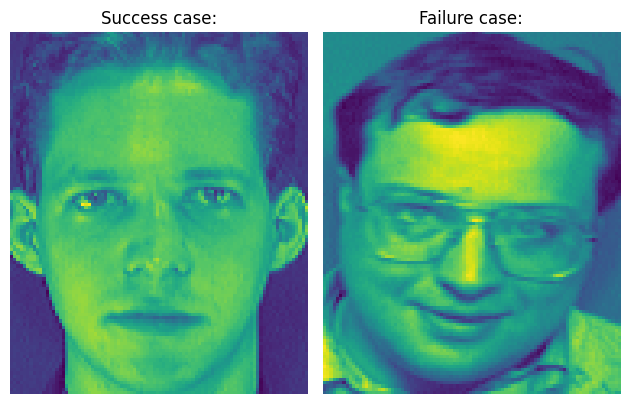

In [ ]:
train_face_no_face_slice = norm_train_face_no_face[:700];
train_labels_slice = train_face_no_face_labels[:700];

lda_projection_mat = lda(train_face_no_face_slice)

print("\nLDA with 500 non-face train images:")
accuracy, correctly_classified_images, incorrectly_classified_images = get_accuracy(lda_projection_mat, train_face_no_face_slice, train_labels_slice, norm_test_face_no_face, test_face_no_face_labels)
print_results(accuracy, correctly_classified_images, incorrectly_classified_images, test_face_no_face)



LDA with 600 non-face train images:
the accuracy is 96.40%
Number of suceesses= 482 / 500
Number of failures= 18 / 500


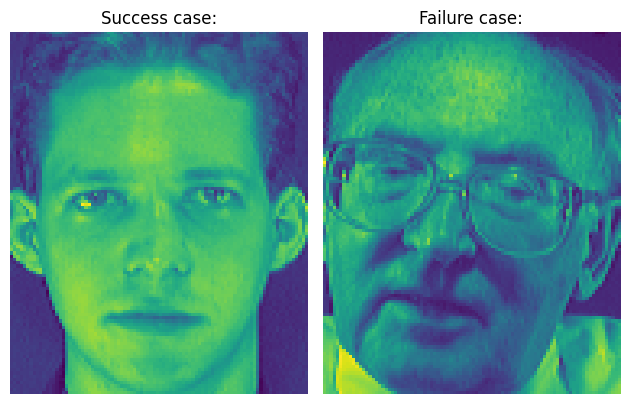

In [ ]:
train_face_no_face_slice = norm_train_face_no_face[:800];
train_labels_slice = train_face_no_face_labels[:800];

lda_projection_mat = lda(train_face_no_face_slice)

print("\nLDA with 600 non-face train images:")
accuracy, correctly_classified_images, incorrectly_classified_images = get_accuracy(lda_projection_mat, train_face_no_face_slice, train_labels_slice, norm_test_face_no_face, test_face_no_face_labels)
print_results(accuracy, correctly_classified_images, incorrectly_classified_images, test_face_no_face)


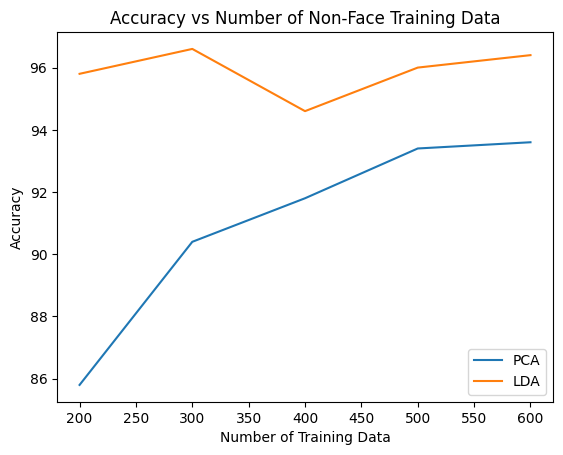

In [ ]:
face_acc_pca = [85.8, 90.4, 91.8, 93.4, 93.6]
face_acc_lda = [95.8, 96.6, 94.6, 96.0, 96.4]
non_face_train_data = [200, 300, 400, 500, 600]

plt.plot(non_face_train_data, face_acc_pca, label='PCA')
plt.plot(non_face_train_data, face_acc_lda, label='LDA')

plt.xlabel('Number of Training Data')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Non-Face Training Data')
plt.legend()

plt.show()

# 8. Bonus

## a. Different Training and Test splits

In [ ]:
# from sklearn.model_selection import train_test_split

# new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(D, labels, test_size=0.3, stratify=labels, random_state=42)

new_X_train = np.empty((0, 10304), dtype=D.dtype)
new_X_test = np.empty((0, 10304), dtype=D.dtype)

i = 0
while i < len(D):
    new_X_train = np.vstack((new_X_train, D[i:i+7]))
    new_X_test = np.vstack((new_X_test, D[i+7:i+10]))
    i += 10

new_y_train = np.repeat(np.arange(1, 41), 7).reshape(-1, 1).ravel()
new_y_test = np.repeat(np.arange(1, 41), 3).reshape(-1, 1).ravel()

# Print the shapes of the resulting training and test datasets
print("Train data shape:", new_X_train.shape)
print("Test data shape:", new_X_test.shape)
print("Test data shape:", new_y_train.shape)
print("Test data shape:", new_y_test.shape)

Train data shape: (280, 10304)
Test data shape: (120, 10304)
Test data shape: (280,)
Test data shape: (120,)


Accuracy for alpha = 0.75: 95.00%
Accuracy for alpha = 0.8: 95.83%
Accuracy for alpha = 0.85: 96.67%
Accuracy for alpha = 0.9: 96.67%
Accuracy for alpha = 0.95: 95.00%


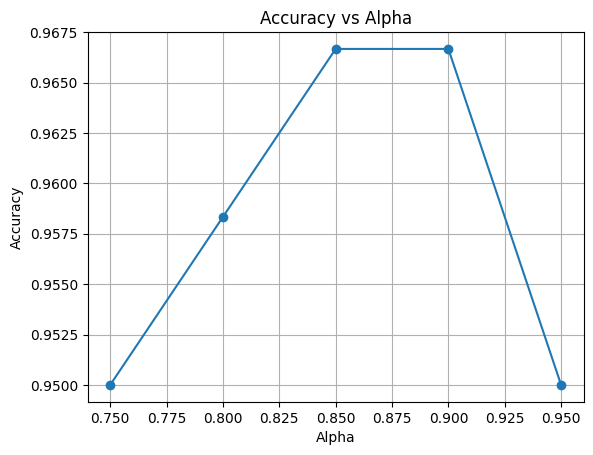

In [ ]:
alpha = [0.75, 0.8, 0.85, 0.9, 0.95]
pca_accuracies_2 = []

eigenvalues, eigenvectors = prepare_pca(new_X_train)
for a in alpha:
    projection_matrix = train_pca(eigenvalues, eigenvectors, a)
    accuracy = test_pca_lda(projection_matrix, new_X_train, new_X_test, new_y_train, new_y_test, 1)
    pca_accuracies_2.append(accuracy)
    print(f"Accuracy for alpha = {a}: {accuracy*100:.2f}%")

plt.plot(alpha, pca_accuracies_2, marker='o')
plt.title('Accuracy vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

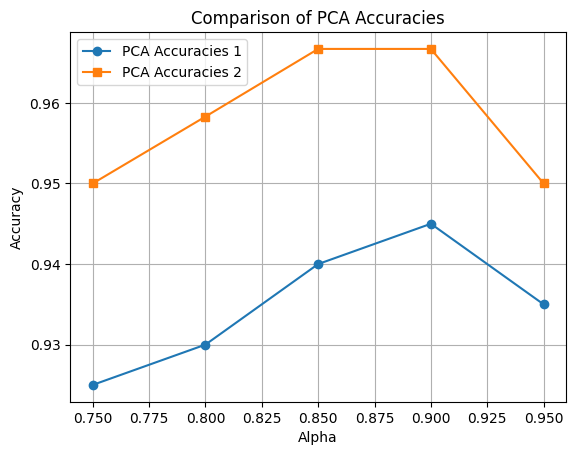

In [ ]:
# Data
alpha_values = [0.75, 0.8, 0.85, 0.9, 0.95]
pca_accuracies_1 = [0.925, 0.93, 0.94, 0.945, 0.935]
pca_accuracies_2 = [0.95, 0.9583, 0.9667, 0.9667, 0.95]

# Plot
plt.plot(alpha_values, pca_accuracies_1, label='PCA Accuracies 1', marker='o')
plt.plot(alpha_values, pca_accuracies_2, label='PCA Accuracies 2', marker='s')

# Add labels and title
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.title('Comparison of PCA Accuracies')
plt.legend()

# Show plot
plt.grid(True)
plt.show()

In [ ]:
projection_matrix = train_lda(new_X_train, 40, 5)
lda_accuracy2 = test_pca_lda(projection_matrix, new_X_train, new_X_test, new_y_train, new_y_test, 1)
print(f"Accuracy for lda: {lda_accuracy2*100:.2f}%")

Accuracy for lda: 92.50%


## b. Variations of PCA and LDA

### PCA Variant

In [ ]:
from sklearn.decomposition import IncrementalPCA

def incremental_pca(X_train, X_test, y_train, y_test, k_nn):
  train_size = X_train.shape[0]
  batch_size = int(train_size / 10)

  ipca = IncrementalPCA(n_components=10, batch_size=batch_size)

  for i in range(0, train_size, batch_size):
      batch = X_train[i:i+batch_size]
      ipca.partial_fit(batch)

  projected_X_train = ipca.transform(X_train)
  projected_X_test = ipca.transform(X_test)

  classifier = KNeighborsClassifier(n_neighbors=k_nn)
  classifier.fit(projected_X_train, y_train)
  y_pred = classifier.predict(projected_X_test)

  accuracy = accuracy_score(y_test, y_pred)
  print(f"Accuracy: {accuracy*100:.2f}%")
  return accuracy

In [ ]:
incremental_pca(X_train, X_test, y_train, y_test, 1)

Accuracy: 90.50%


0.905

### LDA Variant

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

def qda(X_train, X_test, y_train, y_test):
    qda_model = QuadraticDiscriminantAnalysis()

    # Fit the model to the training data
    qda_model.fit(X_train, y_train)

    # Predict the labels for the test data
    y_pred = qda_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    return accuracy

In [ ]:
qda(X_train, X_test, y_train, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy: 0.04


0.04